In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 26 17:17:34 2020

"""
import numpy as np
import os
import xarray as xr
from matplotlib import pyplot as plt
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import interp2d

1. Import data
   path_nadir and path_SWOTpass on OSMOSIS1 domain are imported:

In [2]:
#### SWOT DATA
# Make sure to put this script in the directory below (/data/OSMOSIS/) before you run it

domain_name = 'OSMOSIS1'
addpath = '/home/hafolahbi/Desktop/INTERN/Work/SWOT_prac/data'
os.chdir(r'/home/hafolahbi/Desktop/INTERN/Work/SWOT_prac/data/OSMOSIS')

# Name of the SWOT pass in data/*domain*/ directory
if domain_name == 'OSMOSIS1' :
    path_SWOTpass = 'BOOST-SWOT_SWOT_OSMOSIS_c02_p436.nc'
    path_nadir = 'BOOST-SWOT_J1_nadir_c05_p01.nc'
    # Plotting params
    max_range = 0.2 # Limit for colorbar (SSH in meters) for SSH
    max_range_diff = 0.1 # Limit for colorbar (SSH in meters) for SSH differences

2. Then SWOT and Nadir paths are downloaded

In [3]:
#### Download a SWOT path

roll_error_only = True

all_but_karin = False

with xr.open_dataset(path_SWOTpass, mask_and_scale=True) as (ds_SWOTpass):
    ntime = ds_SWOTpass.time.size
#ds_SWOTpass.info() # Dimension of the dataset
nc = ds_SWOTpass.nC.size
lon_swotpass = np.zeros([ntime, nc])
lon_swotpass [:,:] = ds_SWOTpass.lon
lon_swotpass = np.ma.masked_invalid(lon_swotpass)
lat_swotpass = np.zeros([ntime,nc])
lat_swotpass [:,:] = ds_SWOTpass.lat
lat_swotpass = np.ma.masked_invalid(lat_swotpass)
ssh_swotpass = np.zeros([ntime,nc])
if roll_error_only:
    ssh_swotpass[:, :] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err
elif all_but_karin:
   ssh_swotpass[:, :] = ds_SWOTpass.ssh_model + ds_SWOTpass.roll_err + ds_SWOTpass.phase_err + ds_SWOTpass.timing_err + ds_SWOTpass.bd_err
else: 
    ssh_swotpass[:, :] = ds_SWOTpass.ssh_obs
ssh_swotpass = np.ma.masked_invalid(ssh_swotpass)
ssh_swotpass_truth = np.zeros([ntime, nc]) 
ssh_swotpass_truth[:, :] = ds_SWOTpass.ssh_model # ssh model
ssh_swotpass_truth = np.ma.masked_invalid(ssh_swotpass_truth)



In [4]:
#### Download NADIR path
with xr.open_dataset(path_nadir, mask_and_scale=True) as ds_nadirpass:
    ndtime = ds_nadirpass.time.size
lon_nadirpass = np.zeros([ndtime])
lon_nadirpass[:] = ds_nadirpass.lon
lat_nadirpass = np.zeros([ndtime])
lat_nadirpass[:] = ds_nadirpass.lat
x_al = np.zeros([ndtime])
x_al[:] = ds_nadirpass.x_al
ssh_nadir = np.zeros([ndtime])  
            
ssh_nadir[:] = ds_nadirpass.ssh_obs
ssh_nadir_truth = np.zeros([ndtime])  
ssh_nadir_truth[:] = ds_nadirpass.ssh_model


3. SSH along nadir track (x_al) for Nadir data

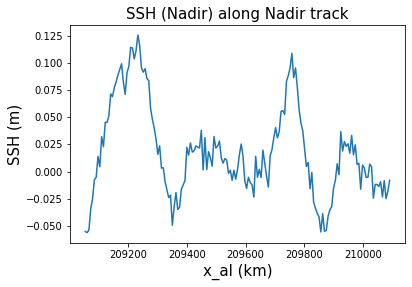

In [5]:
### SSH(m) vs Nadir along track (x_al) for Nadir data
plt.figure()
plt.plot(x_al,ssh_nadir)
plt.ylabel('SSH (m)',fontsize=15)
plt.xlabel('x_al (km)',fontsize=15)
plt.title('SSH (Nadir) along Nadir track', fontsize=15)
plt.show()

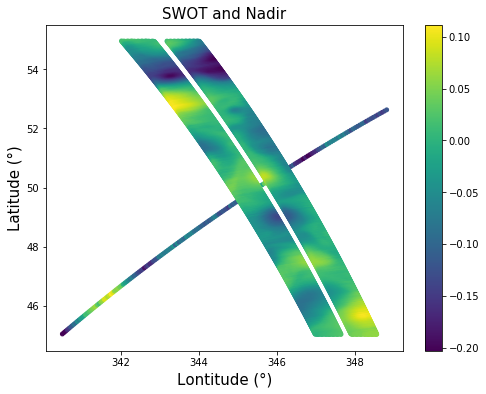

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(lon_nadirpass,lat_nadirpass,c=ssh_nadir,s=15) 
plt.scatter(lon_swotpass, lat_swotpass,c=ssh_swotpass,s=15)
plt.ylabel('Latitude (°)',fontsize=15)
plt.xlabel('Lontitude (°)',fontsize=15)
plt.title('SWOT and Nadir',fontsize=15)
plt.colorbar()

# Interpolation of SWOT on Nadir

In [7]:
# Creating interpolation function
swot2nadir_interp = interp2d(lon_swotpass, lat_swotpass, ssh_swotpass)
swot2nadir_interp


/home/hafolahbi/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=178,179 m=31044 fp=nan s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [8]:
##### Interpolation on Nadir

swot_on_nadir = swot2nadir_interp(lon_nadirpass, lat_nadirpass)
print(swot_on_nadir.shape)

swot_on_nadir = np.diag(swot_on_nadir)

print(swot_on_nadir) # SWOT interpolated on Nadir


##### OBSERVATION

#### We suppose to obtain different values of SSH in the swot_on_nadir interpolation not nan. The possible
# reason for this error is the interpolation function which was not perfectly done as shown in ln 7



(169, 169)
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]


# Modification of Grid

In [9]:
print(np.min(lon_swotpass))
print(np.max(lon_swotpass))
print(np.min(lat_swotpass))
print(np.max(lat_swotpass))

342.011232
348.569888
45.022436
54.962807999999995


In [11]:
### creating a 2D grid
# To create a grid for longitude and latitude using their minimum and maximum values respectively

#lon_swot, lat_swot == lon_swotpass, lat_swotpass


lat_swot = np.arange(45,55,0.196078431)
lon_swot = np.arange(342,348,0.010067114)

# Another observation
# The above lon_swot and lat_swot almost represent the lon_swotpass and lat_swotpass but give the same result
# for swot_on_nadir (i.e nan) just like the original lon_swotpass and lat_swotpass

# Little modification to the grid
lat_swot = np.arange(45,55,0.196078431)*0.1 
lon_swot = np.arange(342,349,0.011744966)*0.1

dx, dy = lon_swot[1]-lon_swot[0], lat_swot[1]-lat_swot[0] # Not a regular grid

# Creating the mesh grid
lat_swotg, lon_swotg = np.meshgrid(lon_swot,lat_swot)


print('lon_swotg = ',lon_swotg.shape)
print('lon_swot_min = ',np.min(lon_swot))
print('lon_swot_max = ',np.max(lon_swot))
print('lat_swot_min = ',np.min(lat_swot))
print('lat_swot_max = ',np.max(lat_swot))
print('dx,dy = ',dx,dy)

lon_swotg =  (52, 597)
lon_swot_min =  34.2
lon_swot_max =  34.899999973598845
lat_swot_min =  4.5
lat_swot_max =  5.499999998099983
dx,dy =  0.0011744965999938017 0.01960784310000019


# SWOT interpolation on nadir for created grid

In [13]:
# Creating interpolation function

swot2nadir_interp = interp2d(lat_swot, lon_swot, ssh_swotpass)# but RectBivariteSpline is better if the grid are regular
#swot2nadir_interp = RectBivariateSpline(nc, ntime, ssh_swotpass)
swot2nadir_interp
#### Interpolation function was created without any error

In [14]:
##### Interpolation on Nadir
swot_on_nadir = swot2nadir_interp(lon_nadirpass, lat_nadirpass)
print(swot_on_nadir.shape)

(169, 169)


In [15]:
swot_on_nadir = np.diag(swot_on_nadir)
print(swot_on_nadir)
np.all(swot_on_nadir==0.05937) # All elements in the matrix are equal
# Unlike the previous swot_on_nadir which gives nan, this swot_on_nadir give value of SSH but is still not
# the expected swot interpolation on nadir that we want. 

[0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937
 0.05937 0.05937 0.05937 0.05937 0.05937 0.05937 0.

True

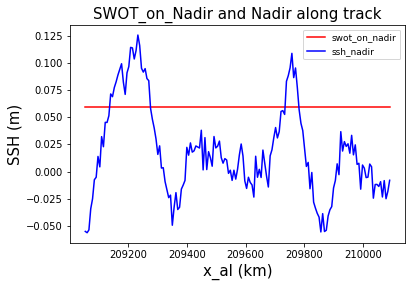

In [16]:
## A plot of SSH SWOT interpolated on nadir and Nadir
plt.figure()
plt.plot(x_al,swot_on_nadir,color='red',label='swot_on_nadir')
#plt.plot(x_al,ssh_nadir_truth)
plt.plot(x_al,ssh_nadir,color='blue',label='ssh_nadir')
plt.ylabel('SSH (m)',fontsize=15)
plt.xlabel('x_al (km)',fontsize=15)
plt.title('SWOT_on_Nadir and Nadir along track', fontsize=15)
plt.legend(fontsize=9)
plt.show()